## Treći zadatak
<hr>

Automatsko numerisanje jednačina

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Importi

In [2]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2, fftshift, ifft2, ifftshift
from numpy.lib.stride_tricks import as_strided
import time
from IPython.display import clear_output
from skimage.exposure import rescale_intensity
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
%matplotlib inline

from IPython.display import display, HTML

HTML centriranje plotova

In [3]:
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

### Funkcije
Pomoćne funkcije korišćene u zadatku.



2D Gausova funkcija

\begin{equation} \label{gauss_2d}
H(x, y) = e^{\displaystyle-\frac{1}{2} \left(\frac{x^2}{D_x^2} + \frac{y^2}{D_y^2} \right)}
\end{equation}

gde su $D_x$ i $D_y$ disperzije po $x$, odnosno $y$ osi respektivno.

In [4]:
def gauss_2D_H(X, Y, Dx, Dy):
    return np.exp(-0.5*((X / Dx) ** 2 + (Y / Dy) ** 2))

Primena restauracije na bazi Vinerovog filtra na jednu (RGB) komponentu slike 
\begin{equation} \label{restauration_wiener}
\hat{F}(u, v) = \displaystyle\frac{|H(u, v)|^2}{|H(u, v)|^2 + K} \frac{G(u, v)}{H(u, v)}
\end{equation}

gde su $(u, v)$ prostorne koordinate slike, $\hat{F}$ procena spektra originalne slike, $G$ spektar ulazne slike, $H$ spektar degradacione funkcije, a $K$ podesiv parametar.

In [5]:
def apply_restoration(G, H, K):
    F_prim = G / H * (np.abs(H) ** 2 / (np.abs(H) ** 2 + K))
    return np.real(ifft2(ifftshift(F_prim)))

Primena restauracije na sve komponente slike

In [6]:
def apply_to_all(img_rgb_double, H, K):
    img_restored = np.zeros((N, M, 3))
    
    for i in range(3):
        G = fftshift(fft2(img_rgb_double[:, :, i]))
        img_restored[:, :, i] = apply_restoration(G, H, K)
    
    return img_restored

Prikaz spektra kao $log(1 + |F|)$

In [7]:
def log_abs_F_foo(F):
    return np.log(1 + np.abs(F))

### Učitavanje

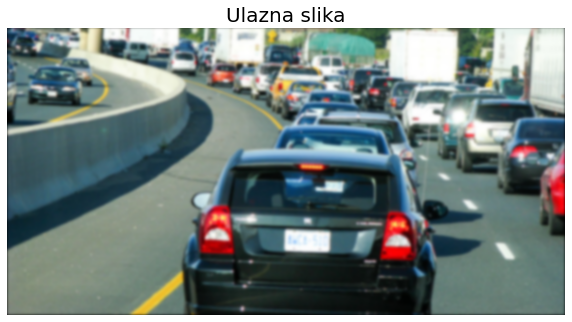

In [8]:
img_rgb = io.imread('sekvence/road_blur.png')

figsize = (10, 10)
fontsize = 20

plt.figure(figsize=figsize)
plt.imshow(img_rgb, cmap='gray')

plt.title('Ulazna slika', fontsize=fontsize)
plt.axis('off')
plt.show()

Ulazna slika je očigledno zamućena, a kako je poznato da se zamućenje može opisati Gausovom funkcijom \ref{gauss_2d} i da jednako pogađa sve komponente (RGB) slike pokušaćemo procenimo disperzije Gausove funkcije po obe komponente - $x$ i $y$.

In [9]:
N = img_rgb.shape[0]  # N   rows    y
M = img_rgb.shape[1]  # M   columns x

img_rgb_double = img_rgb / 255

In [10]:
x = np.arange(0, M, 1)
y = np.arange(0, N, 1)

X, Y = np.meshgrid(x, y)

### Pronalaženje degradacione funkcije

Probanjem različitih vrednosti $D_x$, $D_y$ i $K$ dobijene su sledeće vrednosti koje daju dovoljno dobar rezlutat restauracije.

In [11]:
K = 5e-5
Dx = 60
Dy = 30

H = gauss_2D_H(X - M / 2, Y - N / 2, Dx=Dx, Dy=Dy)

Spektar degradacione funkcije

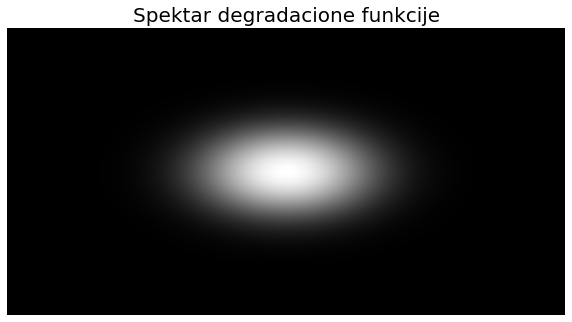

In [12]:
plt.figure(figsize=figsize)
plt.imshow(log_abs_F_foo(H), cmap='gray')

plt.title('Spektar degradacione funkcije', fontsize=fontsize)
plt.axis('off')
plt.show()

### Restauracija

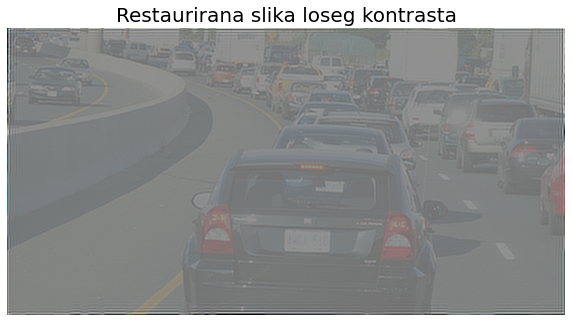

In [13]:
img_restored = apply_to_all(img_rgb_double, H, K)

img_restored -= np.amin(img_restored)
img_restored /= np.amax(img_restored)

plt.figure(figsize=figsize)
plt.imshow(img_restored)

plt.title('Restaurirana slika lošeg kontrasta', fontsize=fontsize)
plt.axis('off')
plt.show()

Iako je slika sada restaurirana, ona nije od velike koristi jer je jako lošeg kontrasta.  

Popravka kontrasta restaurirane slike

In [14]:
in_min = [110, 110, 110]  # opseg vrednosti piksela slike
in_max = [150, 150, 150]

img_restored_contrasted = np.zeros_like(img_restored)

for i in range(3):
#     hist_f, bin_edges = np.histogram(img_restored[:, :, i].flatten()*255,
#                                      bins=256, range=(0, 255))
    
#     plt.plot(bin_edges[0:-1], hist_f)
#     plt.show()
    img_contrast_stretched = np.array(img_restored[:, :, i] * 255)

    img_contrast_stretched[img_contrast_stretched < in_min[i]] = in_min[i]
    img_contrast_stretched[img_contrast_stretched > in_max[i]] = in_max[i]

    img_contrast_stretched = np.interp(img_contrast_stretched, [in_min[i], in_max[i]], [0, 255])

    
    img_restored_contrasted[:, :, i] = img_contrast_stretched
    

    

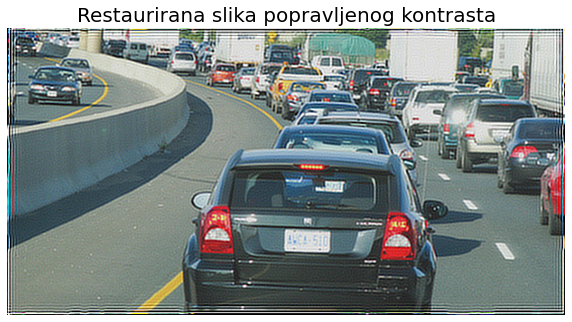

In [15]:
img_restored_contrasted = img_restored_contrasted.astype(np.uint8)
plt.figure(figsize=figsize)
plt.imshow(img_restored_contrasted)

plt.title('Restaurirana slika popravljenog kontrasta', fontsize=fontsize)
plt.axis('off')
plt.show()

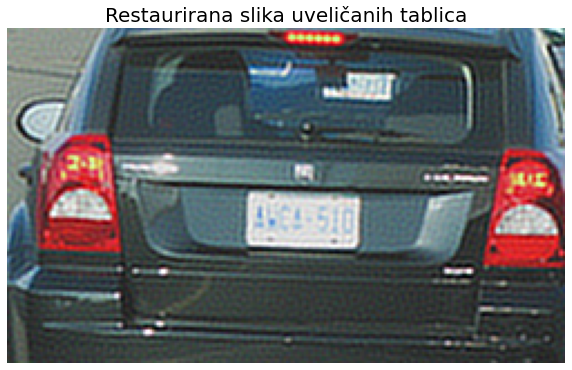

In [16]:
img_restored_contrasted = img_restored_contrasted.astype(np.uint8)
plt.figure(figsize=figsize)
plt.imshow(img_restored_contrasted[150:300, 200:450])

plt.title('Restaurirana slika uveličanih tablica', fontsize=fontsize)
plt.axis('off')
plt.show()

Sa slike se može razaznati registarski broj automobila **AWCA - 510**

Apdejtovanje numerisanja jednačina

In [17]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>